# Demo
## Vortex dynamics

In this example, we are going to simulate vortex core dynamics. After creating a vortex structure, we are first going to displace it by applying an external magnetic field. We will then turn off the external field, and compute the time-development of the system, and then be able to see the dynamics of the vortex core.

The sample is a two-dimensional Permalloy disk sample with $r=50 \,\text{nm}$ edge length and $10\,\text{nm}$ thickness. Its energy equation consists of ferromagnetic exchange, Zeeman, and demagnetisation energy terms:
    
$$E = \int_{V} \left[-A\mathbf{m}\cdot\nabla^{2}\mathbf{m} - \mu_{0}M_\text{s}\mathbf{m}\cdot\mathbf{H} + w_\text{d}\right] \text{d}V,$$

where $A = 13 \,\text{pJ}\,\text{m}^{-1}$ is the exchange energy constant, $M_\text{s} = 8 \times 10^{5} \,\text{A}\,\text{m}^{-1}$ magnetisation saturation, $w_\text{d}$ demagnetisation energy density, $\mathbf{H}$ an external magnetic field, and $\mathbf{m}=\mathbf{M}/M_\text{s}$ the normalised magnetisation field.

The magnetisation dynamics is governed by the Landau-Lifshitz-Gilbert equation consisting of precession and damping terms:

$$\frac{\partial\mathbf{m}}{\partial t} = -\frac{\gamma_{0}}{1+\alpha^{2}}\mathbf{m}\times\mathbf{H}_\text{eff} - \frac{\gamma_{0}\alpha}{1+\alpha^{2}}\mathbf{m}\times(\mathbf{m}\times\mathbf{H}_\text{eff}),$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and $\alpha = 0.05$ is the Gilbert damping.

The (initial) magnetisation field is a vortex state, whose magnetisation at each point $(x, y, z)$ in the sample can be represented as $(m_{x}, m_{y}, m_{z}) = (-cy, cx, 0.1)$, with $c = 10^{-9} \text{m}^{-1}$.

In [1]:
# Some initial configurations
%config InlineBackend.figure_formats = ['svg']  # output matplotlib plots as SVG
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_rows = 5
pd.options.display.float_format = "{:,.2e}".format

## System initialisation

The Ubermag code for defining the micromagnetic system is:

In [2]:
import discretisedfield as df
import micromagneticmodel as mm

# Geometry
r = 50e-9  # Radius of the thin nano magnetic disk (m)
thickness = 10e-9  # sample thickness (m)

# Material (Permalloy) parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 13e-12  # exchange energy constant (J/m)

# Dynamics (LLG equation) parameters
gamma0 = mm.consts.gamma0  # gyromagnetic ratio (m/As)
alpha = 0.05  # Gilbert damping

system = mm.System(name="vortex_dynamics")

# Energy equation. We omit Zeeman energy term, because H=0.
system.energy = mm.Exchange(A=A) + mm.Demag()

# Dynamics equation
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)


# initial magnetisation state
def m_init(point):
    x, y, _ = point
    c = 1e9  # (1/m)
    return (-c * y, c * x, 0.1)


# Defining the geometry of the material as a circular disk
def Ms_func(point):
    x, y, _ = point
    if x**2 + y**2 <= r**2:
        return Ms
    else:
        return 0


# Sample's centre is placed at origin
region = df.Region(p1=(-r, -r, -thickness / 2), p2=(r, r, thickness / 2))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 10e-9))

system.m = df.Field(mesh, nvdim=3, value=m_init, norm=Ms_func, valid="norm")

The system object is now defined and we can investigate some of its properties:

In [3]:
system.energy

Exchange(A=1.3e-11) + Demag()

In [4]:
system.dynamics

Precession(gamma0=221276.14872118403) + Damping(alpha=0.05)

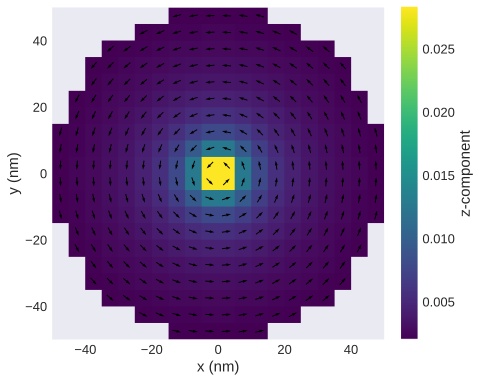

In [5]:
system.m.orientation.sel("z").mpl()

## Energy minimisation
To carry out micromagnetic simulation, we need to use a micromagnetic calulator. We are going to use OOMMF for this.
We can now relax the system in the absence of external magnetic field using energy minimisation driver (`MinDriver`):

Running OOMMF (ExeOOMMFRunner)[2023/10/23 16:17]... (0.4 s)


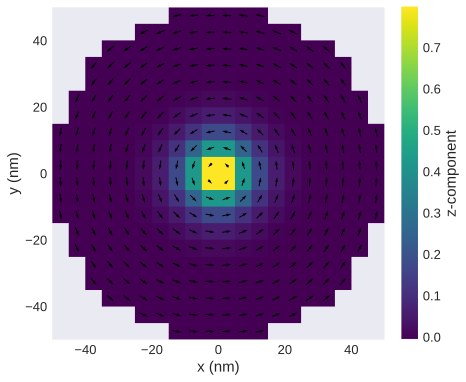

In [6]:
import oommfc as oc  # Micromagnetic Calculator

md = oc.MinDriver()
md.drive(system)

system.m.orientation.sel("z").mpl()

## Displacement with magnetic field

Now, we have a relaxed vortex state, with its core at the centre of the sample. As the next step, we want to add an external magnetic field $H=3.4 \times 10^{4}\,\text{Am}^{-1}$ in the positive $x$-direction to displace the vortex core. We do that by adding the Zeeman energy term to the energy equation:

Running OOMMF (ExeOOMMFRunner)[2023/10/23 16:17]... (0.3 s)


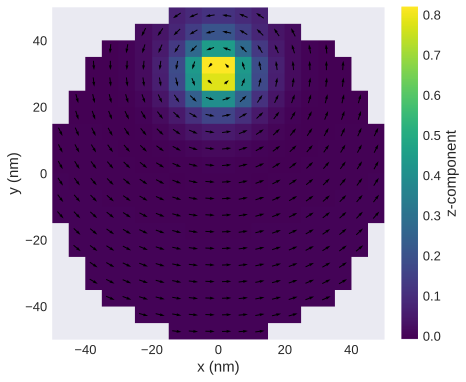

In [7]:
H = (3.4e4, 0, 0)  # an external magnetic field (A/m)

system.energy += mm.Zeeman(H=H)

md.drive(system)
system.m.orientation.sel("z").mpl()

## Free relaxation

The vortex core is now displaced in the positive $y$-direction. As the last step, we are going to turn off the external magnetic field and simulate dynamics using `TimeDriver`. We are going to run simulation for $20\,\text{ns}$ and save the magnetisation in $500$ steps.

In [8]:
system.energy -= mm.Zeeman(H=H)

td = oc.TimeDriver()
td.drive(system, t=20e-9, n=500, verbose=2)

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/500 files written [00:00]

Running OOMMF (ExeOOMMFRunner)[2023/10/23 16:17] took 12.4 s


The final magnetisation state shows that the vortex core has moved back to the sample's centre.

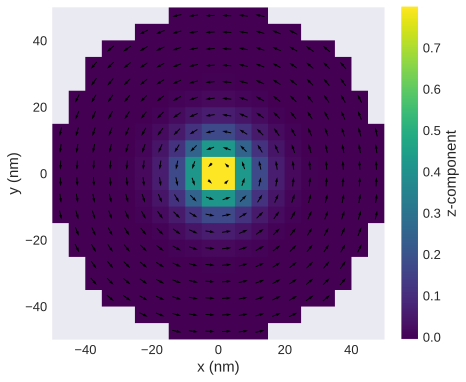

In [9]:
system.m.orientation.sel("z").mpl()

## Data analysis

### Spatially averaged data
The table with scalar data saved during the simulation. Each row corresponds to one of the 500 saved configurations. We only show selected columns.

In [10]:
system.table.data[["t", "mx", "my", "mz", "E"]].head()

,t,mx,my,mz,E
0,4.00e-11,4.18e-01,5.03e-02,1.82e-02,3.94e-18
1,8.00e-11,4.27e-01,1.92e-01,1.07e-02,3.89e-18
2,1.20e-10,4.26e-01,2.63e-01,3.90e-02,3.86e-18
3,1.60e-10,3.05e-01,2.82e-01,7.84e-03,3.83e-18
4,2.00e-10,2.57e-01,3.97e-01,2.66e-02,3.80e-18


We can now plot the average $m_{x}$, $m_{y}$ and $m_{z}$ values as taken from the table as a function of time to give us an idea of the vortex core position.

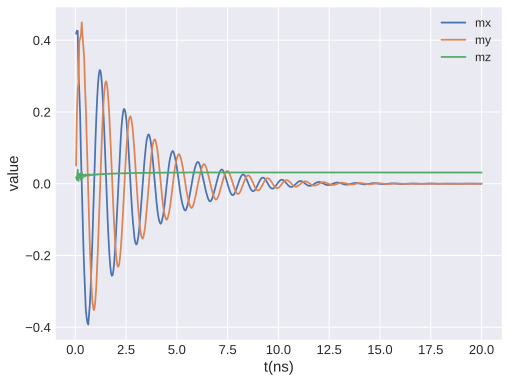

In [11]:
system.table.mpl(y=["mx", "my", "mz"])

### Spatially resolved data
Finally, we are going to have a look at the magnetisation field at different time-steps using `micromagneticdata`.

In [12]:
import micromagneticdata as mdata

data = mdata.Data(system.name)
data.info

,drive_number,date,time,driver,n_threads,t,n
0,0,2023-10-23,16:17:40,MinDriver,None,NaN,NaN
1,1,2023-10-23,16:17:40,MinDriver,None,NaN,NaN
2,2,2023-10-23,16:17:41,TimeDriver,None,2.00e-08,5.00e+02


To interactively inspect the time dependent magnetisation, we use `data[-1]` to refer to the last drive.

In [13]:
data[-1].hv(
    kdims=["x", "y"], vdims=["x", "y"], scalar_kw={"cmap": "viridis", "clim": (0, Ms)}
)

:DynamicMap   [t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

We can now compute winding number using operators from `discretisedfield`:
$$ S = \frac{1}{4\pi}\iint q \,\,\text{d}x\text{d}y = \frac{1}{4\pi}\iint\mathbf{m}\cdot\left(\frac{\partial \mathbf{m}}{\partial x} \times \frac{\partial \mathbf{m}}{\partial y~}\right)\text{d}x\text{d}y$$

In [14]:
import math

m = system.m.orientation.sel("z")
S = m.dot(m.diff("x").cross(m.diff("y"))).integrate() / (4 * math.pi)
S

array([0.42290507])

The winding number is commonly used and there is a predefined function in `discretisedfield.tools`. To get more accurate results we use a different numerical method than just "naively" evaluating the integral.

In [15]:
df.tools.topological_charge(system.m.sel("z"), method="berg-luescher")

0.5024556893362209

We can also plot the topological charge density in an interactive plot.

In [16]:
data[-1].register_callback(
    lambda f: df.tools.topological_charge_density(f.sel("z"))
).hv(kdims=["x", "y"])

:DynamicMap   [t]
   :Image   [x,y]   (field)

### Trajectory of the vortex core

We can compute the trajectory of the vortex core via the center of mass of the topological charge:
$$\mathbf{R} = \frac{ \int \mathbf{r} \rho(\mathbf{r}) d^2\mathbf{r}}{\int \rho(\mathbf{r}) d^2\mathbf{r}}. $$

In [17]:
rho = df.tools.topological_charge_density(system.m.sel("z"))
r = system.m.sel("z").mesh.coordinate_field()
R = (r * rho).integrate() / rho.integrate()
R

array([6.24115027e-12, 4.54330909e-12])

Now, we need to find the center of the vortex at each time step, this can be achieved by taking the data from last drive.

In [18]:
def compute_vortex_centre(drive):
    x_coords = []
    y_coords = []

    r = drive[0].sel("z").mesh.coordinate_field()

    for m in drive:
        tcd = df.tools.topological_charge_density(m.sel("z"))
        centre_of_mass = (r * tcd).integrate() / tcd.integrate()
        x_coords.append(centre_of_mass[0])
        y_coords.append(centre_of_mass[1])

    return pd.DataFrame(
        {"t": drive.table.data["t"], "pos x": x_coords, "pos y": y_coords}
    )

In [19]:
pos_pol_plus = compute_vortex_centre(data[-1])

We can now plot the vortex trajectory on top of the initial configuration.

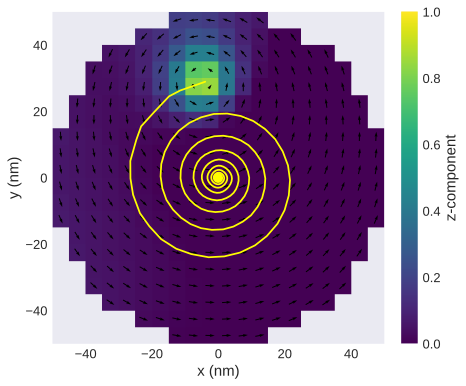

In [20]:
fig, ax = plt.subplots()
data[-1][0].orientation.sel("z").mpl(ax=ax, scalar_kw={"clim": (0, 1)})
ax.plot(pos_pol_plus["pos x"] * 1e9, pos_pol_plus["pos y"] * 1e9, c="yellow")

Finally, let us delete all simulation files:

In [21]:
oc.delete(system)